# Visão Computacional
## Segmentação de caractéres

Curso: Ciência da Computação - 8º Período

Alunos:

* Henrique Matheus Alves Nunes
* João Victor de Lima
* Lucas Eduardo de Andrade Cavalari
* Matheus Richter
* Vinicius Sakamoto Tasca

# Imports

In [2]:
import os
import cv2
import random
import string
import numpy as np
import matplotlib.pyplot as plt

# Global variables

In [3]:
img_folder = './Images/'
img_names = os.listdir(img_folder)

In [4]:
shapes = [cv2.imread(img_folder+i).shape for i in img_names]

In [5]:
cross_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8)
h_line_kernel = np.array([[0,0,0],[1,1,1],[0,0,0]], np.uint8)
v_line_kernel = np.array([[0,1,0],[0,1,0],[0,1,0]], np.uint8)

# Global functions

In [6]:
def morf_opening(img,kernel):
  im_dilate = cv2.dilate(img,kernel)
  im_open = cv2.erode(im_dilate,kernel)
  return im_open

In [7]:
def morf_closing(img,kernel):
  im_erode = cv2.erode(img,kernel)
  im_close = cv2.dilate(im_erode,kernel)
  return im_close

# Experimental implementation

1. Filter
2. Segmentation
    1. Color segmentation
    2. Binarisation
3. Erosion/dilation
4. Component segmentation

### Original image

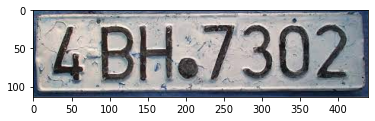

In [8]:
'''
Here we load one of the images to experiment what methods we should use in the
actual implementations of the task
'''

# Original image
im_test = cv2.imread(img_folder+img_names[0], cv2.IMREAD_COLOR)
plt.imshow(im_test)
plt.show()

### Color segmentation

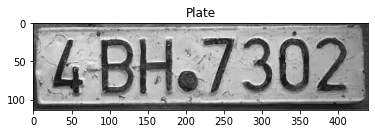

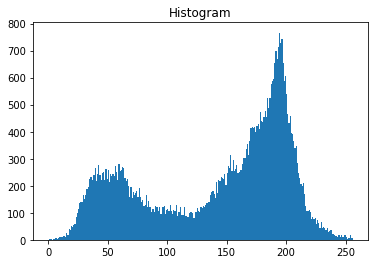

In [9]:
'''
In this cell we convert our image to gray scale, so we can separate the characters
from the background of the image. We ploted a histogram of the pixels, so it is
easier for us to choose a number to use in the threshold function
'''

# Color segmentation
gray = cv2.cvtColor(im_test, cv2.COLOR_RGB2GRAY)

plt.title('Plate')
plt.imshow(gray, cmap='gray')
plt.show()

plt.title('Histogram')
plt.hist(gray.ravel(), 256,[0,256])
plt.show()

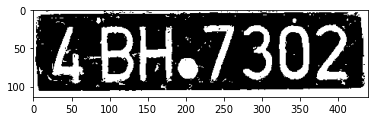

In [10]:
'''
Here we apply threshold to make the image black and white. We use the value
chosen by analysing the hitogram in the cell above 
'''

# Thresholding
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.show()

### Filtering

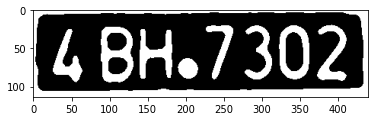

In [11]:
'''
Here we apply a filter to see if it's going to be useful for the
treatment of the image
'''

im_filtered = cv2.medianBlur(thresh,11)
plt.imshow(im_filtered, cmap='gray')
plt.show()

### Morphology

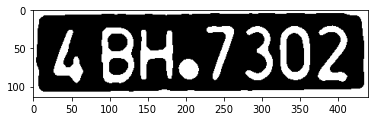

In [12]:
'''
In this cell and below we analyse the use of opening and
closing operations in the image.
'''

# Opening
im_open = morf_opening(im_filtered, np.ones((4,4)))
plt.imshow(im_open, cmap='gray')
plt.show()

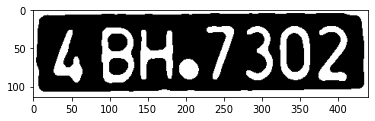

In [13]:
# Closing
im_close = morf_closing(im_filtered, v_line_kernel)
im_close = morf_closing(im_close, cross_kernel)
im_close = morf_closing(im_filtered, np.ones((4,4)))
plt.imshow(im_close, cmap='gray')
plt.show()

### Component segmentation

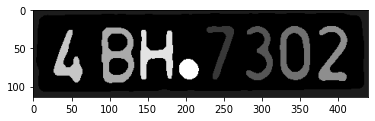

In [14]:
'''
Here we use a function to get the character in the image
'''

# component segmentation
num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(im_close , 4, cv2.CV_32S)
plt.imshow(cc_image,cmap='gray')

228 21 36 70
213945


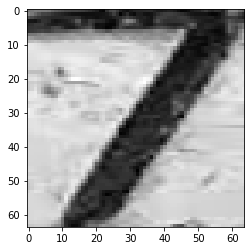

280 21 35 71
249390


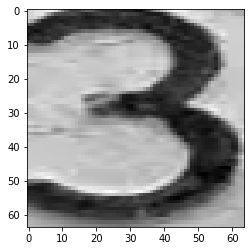

324 21 40 71
354450


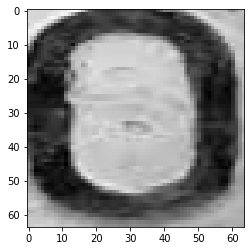

375 21 38 72
298605


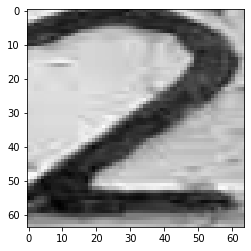

90 23 43 73
448035


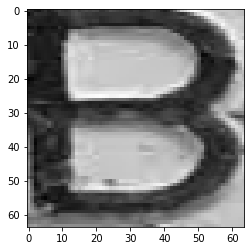

27 26 38 69
276930


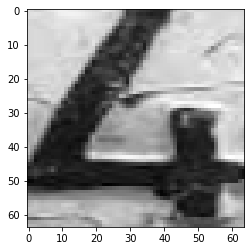

141 26 43 65
332265


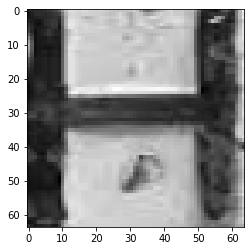

In [15]:
'''
Here we loop through the result we got from the function in the cell above
and we choose a limit for the height of the components we want 
'''

for i in range(num_labels):
  temp = cc_image.copy()
  
  temp[cc_image == i] = 255
  temp[cc_image != i] = 0

  x,y,w,h = stats[i][:4]
  area = stats[i][4]
  cx,cy = centroids[i]
  component = gray[y:y+h, x:x+w]
  component = cv2.resize(component,(64,64))

  if h > 40 and h < 80:
    print(x,y,w,h)
    # plt.hist(temp.ravel(), 256, [0,256])
    print(sum(temp.ravel()))
    plt.show()
    plt.imshow(component, cmap='gray')
    plt.show()

# Actual implementation

In [16]:
# char images dataset
def gen_chars(c):
  font = cv2.FONT_HERSHEY_SIMPLEX
  img = np.zeros((16,16,3), np.uint8)
  char_img = cv2.putText(img, c, (1,16), font, 0.7, (255,255,255), 2, cv2.LINE_AA)
  return char_img

In [17]:
chars = set(list(string.ascii_uppercase) + list(string.digits))
chars_img = {c:gen_chars(c) for c in chars}

In [18]:
# funções de manipulação e leitura de imagens

def draw_rectangles(im, pos):
  new_im = im
  for p in pos:
    new_im = cv2.rectangle(new_im, (p[0],p[1]), (p[0]+p[2],p[1]+p[3]), (255,0,0), 2)
  return new_im

def get_char(im):
  im = morf_closing(im, np.ones((9,9)))
  pixels = sum(im.ravel())

  ini_char = list(chars)[random.randint(0,len(chars)-1)]
  diff = abs(sum(chars_img[ini_char].ravel()) - pixels)
  menor = ini_char
  for c, img in chars_img.items():
    d = abs(sum(img.ravel()) - pixels)
    if d < diff:
      menor = c

  return menor
  # return pixels.__str__()

In [54]:
def segment(img):
  # processing
  im = cv2.imread(img, cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  im_filtered = cv2.medianBlur(thresh,3)
  im_open = morf_opening(im_filtered, np.ones((1,1)))
  # im_norm = cv2.resize(im_open, (250,100))
  num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(im_open , 4 , cv2.CV_32S)
  
  # extração dos componentes
  components_n, components_s, components_l, components_xl = [], [], [], []
  p_chars = ''
  for i in range(num_labels):
    x,y,w,h = stats[i][:4]
    area = stats[i][4]
    cx,cy = centroids[i]
    component = gray[y:y+h, x:x+w]
    component = cv2.resize(component,(16,16))

    if h > 70 and h < 104:
      components_n.append([x,y,w,h, component])
    
    if h > 50 and h < 70:
        components_s.append([x,y,w,h, component])

    if h > 100 and h < 200 and w < 100:
      components_l.append([x,y,w,h, component])

    if h > 200 and h < 500 and w < 800:
      components_xl.append([x,y,w,h, component])
    
  components = components_s if (len(components_s) > len(components_n)) else (components_n if (len(components_n) > len(components_l)) else components_l if (len(components_l) > len(components_xl)) else components_xl)
  recs = [c[:4] for c in components]

  for c in components:
    cc = get_char(c[4])
    p_chars += cc
    # chars += get_char(c[4]) + ' '

  s_img = draw_rectangles(im, recs)

  return components, s_img, p_chars

0,1,2,4,5,6,9,10 -- funcionou

3,7,8 -- não funcionou

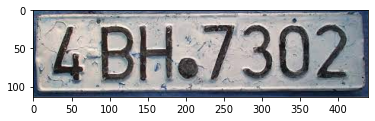

U1IUJJY


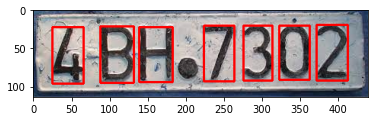

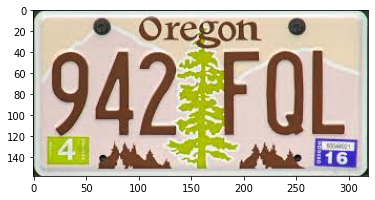

U1UJUY


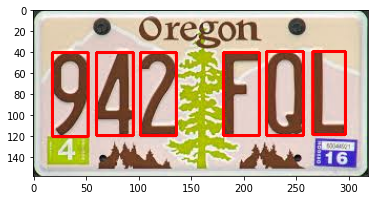

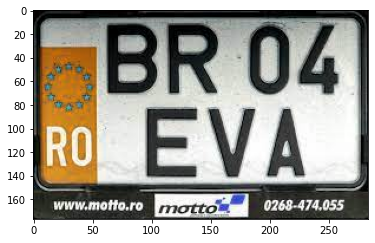

YUUUUYI


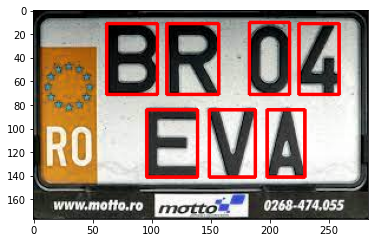

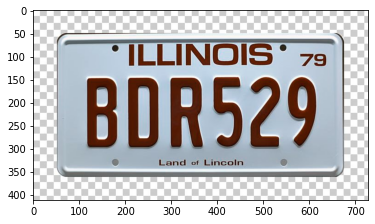

UYUYYU


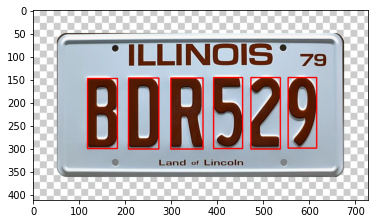

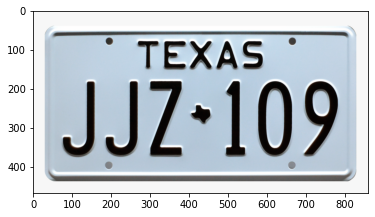

1UYUUY


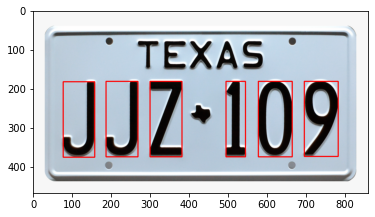

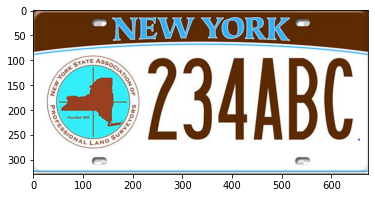

UUUUUU


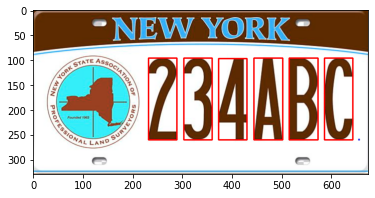

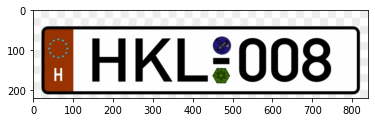

UYUUUU


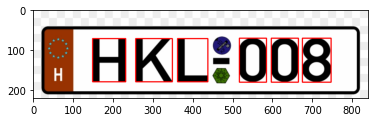

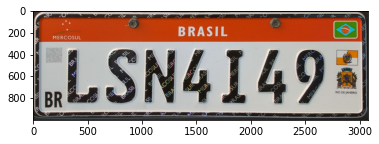

YJYYUUU


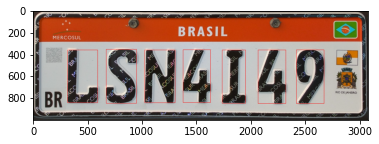

In [55]:
for i in [0,1,2,4,5,6,9,10]:
  im_name = img_folder+img_names[i]
  im = cv2.imread(im_name, cv2.IMREAD_COLOR)
  plt.imshow(im)
  plt.show()
  comps, im_s, p_chars = segment(im_name)
  print(p_chars)

  # chars = chars.split(' ')
  # for c in range(len(comps)):
  #   print(chars[c])
  #   plt.imshow(comps[c][4], cmap='gray')
  #   plt.show()

  plt.imshow(im_s)
  plt.show()
  print('='*100)

# Thoughts and discussion

### Etapas
Durante a implementação experimental nós verificamos o resultado da aplicação de filtros nas imagens das placas e verificamos que a utilização deles não fazia uma diferença muito significativa, no entanto em alguns casos, como no caso da placa 3, ocorria uma redução nos ruídos. Por essa razão aplicamos o medianBlur na implementação propriamente dita.

Além da constatação anterior, foi gerado o histograma da distribuição dos pixels das imagens. Apartir desse processo foi escolhido um valor para realizar a binarização da cor das imagens. O valor definido foi 120, pois era um valor que funcionava para a maioria das placas. Então esse foi valor utilizado na implementação.

Outra etapa experimental foi a aplcação de morfologia nas imagens. Foram aplicadas as operações de abertura e fechamento em algumas imagens, porém o efeito obtido não foi o desejado em nenhuma das placas. As duas operações, quando aplidas à placa toda, não fizeram diferença considerável, utilizando os kernels que definimos. Quando aplicadas apenos nos caractéres, as operações, ou faziam com que a letra/número ficasse desconexo ou "fechado" (preenchia os espaços que deveriam ficar vazios). Por conta desses resultados foi decidido não utilizar morfologia na implementação.

A última etapa dos experimentos foi a segmentação dos componentes das imagens. Nessa etapa foram analisadas as possibilidades de altura que os caractéres poderiam ter em cada placa. Foram percebidos três tamanhos diferentes que os caractéres poderiam ter, entre 70 e 104 pixels de altura, entre 50 e 70 pixels ou mais de 104 pixels de altura. Devido a essa percepção esses tamanhos foram utilizados na implementação.

A implementação da tarefa possui as etapas acima e além delas possui as etapas de destaque dos caracteres nas placas e da classificação dos caractéres. Na primeira etapa, utilizamos as estatisticas de altura e largura, retornadas pela função utlizada na etapa de segmentação de componentes, para saber o tamanho dos retangulos que a serem desenhados e a sua posição. Na segunda etapa, foi criado um dataset de imagens com letras maiúsculas e números, para serem comparados com os caractéres extraídos e classificá-los de acordo com diferenças de pixels de cada um. A classificação ocorre calculando o módulo da diferença entre cada caractér extraído com os caractéres do dataset gerado, a o caractér com a menor diferença encontrado é o escolhido.

### Análise
Ao executar a tarefa, foi verificado que para a maioria das placas a segmentação funciona muito bem. Porém para as imagens 3, 7 e 8, não foi possível realizar a segmentação. A imagem 3 possui muitos ruídos, o que dificultou o pré-processamento e impossíbilitou a segmentação de ocorrer corretamente, pois os caractéres ficavam desconexos.

Além disso foi verificado que a classificação dos caractéres não funcionou bem, pois sem o uso de extração de características e aprendizagem de máquina ou deep learning, as técnicas disponíveis para essa tarefa são muito ineficientes. Apenas comparar uma imagem com outra, analisando a diferença na quantidade de pixels não é o bastante para encontrar a classificação correta, pois essa é uma característica que pode ser muito similar para muitos caractéres, por exemplo '1', 'I' e 'T' ou '0' e 'O', que além da quantidade de pixels ser próxima, possuem formatos muito semelhantes.